# Notebook 6: Phases of the Ising Model with Logistic Regression


## Learning Goal
The goal of this notebook is to show how one can employ Logistic Regression to classify the states of the 2D Ising model according to their phase. We will discuss overfitting, regularization, and learn how to use the scikit-learn library. We will also examine the role of the optimizer in making predictions.

## Overview

The energy function of the classical Ising model is given by

$$ H = -J\sum_{\langle ij\rangle}S_{i}S_j,\qquad \qquad S_j\in\{\pm 1\} $$

where the lattice site indices $i,j$ run over all nearest neighbors of a 2D square lattice, and $J$ is some arbitrary interaction energy scale. We adopt periodic boundary conditions. Onsager proved that this model undergoes a thermal phase transition in the thermodynamic limit from an ordered ferromagnet with all spins aligned to a disordered phase at the critical temperature $T_c/J=2/\log(1+\sqrt{2})\approx 2.26$. For any finite system size, this critical point is expanded to a critical region around $T_c$.



An interesting question to ask is whether one can train a statistical model to distinguish between the two phases of the Ising model. If successful, this can be used to locate the position of the critical point in more complicated models where an exact analytical solution has so far remained elusive. 

In other words, given an Ising state, we would like to classify whether it belongs to the ordered or the disordered phase, without any additional information other than the spin configuration itself. This categorical machine learning problem is well suited for logistic regression. Notice that, for the purposes of applying logistic regression, the 2D spin state of the Ising model will be flattened out to a 1D array, so it will not be easy to learn information about the structure of the contiguous ordered 2D domains [see figure below]. Such information can be incorporated using other methods such as multi-layer deep convolutional neural networks (CNNs), see Secs. IX, X and XI of the review and the corresponding notebooks.

## The 2D Ising Dataset

To this end, we consider the 2D Ising model on a $40\times 40$ square lattice, and use Monte-Carlo (MC) sampling to prepare $10^4$ states at every fixed temperature $T$ out of a pre-defined set $T\in[0.25,0.5,\cdots,4.0]$. Using Onsager's criterion, we can assign a label to each state according to its phase: $0$ if the state is disordered, and $1$ if it is ordered. Our goal is to predict the phase of a sample given the spin configuration.

It is well-known that, near the critical temperature $T_c$, the ferromagnetic correlation length diverges which, among other things, leads to a critical slowing down of the MC algorithm. Therefore, we expect identifying the phases to be harder in the critical region. With this in mind, consider the following three types of states: ordered ($T/J<2.0$), critical ($2.0\leq T/J\leq 2.5)$ and disordered ($T/J>2.5$). We use both ordered and disordered states to train the logistic regressor and once the supervised training procedure is complete, we evaluate the performance of our classification model on unseen ordered, disordered and critical states. 

In [8]:
import numpy as np

import warnings
#Comment this to turn on warnings
#warnings.filterwarnings('ignore')

np.random.seed() # shuffle random seed generator

# Ising model parameters
L=40 # linear system size
J=-1.0 # Ising interaction
T=np.linspace(0.25,4.0,16) # set of temperatures
T_c=2.26 # Onsager critical temperature in the TD limit

# Loading in the Ising dataset
We now load in the data which is hosted on Pankaj Mehta's [website](http://physics.bu.edu/~pankajm/MLnotebooks.html).

In [23]:
import pickle, os
from urllib.request import urlopen 

# url to data
url_main = 'https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/';

######### LOAD DATA
# The data consists of 16*10000 samples taken in T=np.arange(0.25,4.0001,0.25):
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl" 
# The labels are obtained from the following file:
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"


#DATA
data = pickle.load(urlopen(url_main + data_file_name)) # pickle reads the file and returns the Python object (1D array, compressed bits)
data = np.unpackbits(data).reshape(-1, 1600) # Decompress array and reshape for convenience
data=data.astype('int')
data[np.where(data==0)]=-1 # map 0 state to -1 (Ising variable can take values +/-1)

#LABELS (convention is 1 for ordered states and 0 for disordered states)
labels = pickle.load(urlopen(url_main + label_file_name)) # pickle reads the file and returns the Python object (here just a 1D array with the binary labels)

# Constructing the training and the test sets

In [24]:
from sklearn.model_selection import train_test_split

###### define ML parameters
num_classes=2
train_to_test_ratio=0.5 # training samples

# divide data into ordered, critical and disordered
X_ordered=data[:70000,:]
Y_ordered=labels[:70000]

X_critical=data[70000:96000,:] # 100000
Y_critical=labels[70000:96000] # 100000

X_disordered=data[100000:,:]
Y_disordered=labels[100000:]

del data,labels

# define training and test data sets
X=np.concatenate((X_ordered,X_disordered))
Y=np.concatenate((Y_ordered,Y_disordered))

# pick random data points from ordered and disordered states 
# to create the training and test sets
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,train_size=train_to_test_ratio,test_size=1.0-train_to_test_ratio)

# full data set
X=np.concatenate((X_critical,X))
Y=np.concatenate((Y_critical,Y))

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')

X_train shape: (65000, 1600)
Y_train shape: (65000,)

65000 train samples
26000 critical samples
65000 test samples


# Visualizing the states

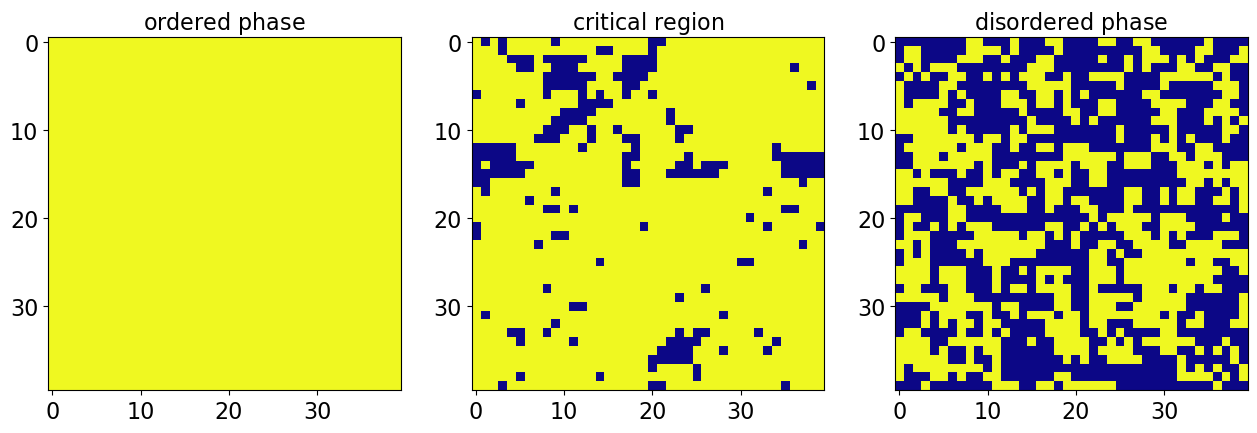

In [26]:
##### plot a few Ising states
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set colourbar map
cmap_args=dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L,L),**cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$',fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L,L),**cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$',fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

plt.show()

## Cost function, optimizers, regularizers, and performance metrics

In Sec. VII of the review, we have shown that the cross-entropy is a natural cost function used for training a logistic regressor. As we already mentioned, minimizing it requires the use of numerical toolboxes. Here, we compare the performance of two different optimization routines: a `liblinear` [the default one for scikit's logistic regression], and stochastic gradient descent (SGD) [see Sec. IV of the review for more details].

It is important to note that all these methods have built-in regularizers. Indeed, we did not discuss the role of the regularisor explicitly in the context of Logistic Regression extensively, yet this concept is crucial in order to prevent overfitting, and we encourage the interested reader to play with the different regularization types and regularization strengths and compare model performances. 

Below, we define the accuracy of a classification model on a given data set as the percentage of correctly classified data points. Comparing the accuracy on the training and test data, we obtain a good estimate of the degree of overfitting. Well-trained models do not overfit the data, which is reflected in an almost equal performance on the training and test data sets [recall that the test set consists of samples which the model has not been trained on]. 

# Run the cell below (this may take several minutes)

In [27]:
###### apply logistic regression
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier


# define regularisation parameter
lmbdas=np.logspace(-5,5,11)

# preallocate data
train_accuracy=np.zeros(lmbdas.shape,np.float64)
test_accuracy=np.zeros(lmbdas.shape,np.float64)
critical_accuracy=np.zeros(lmbdas.shape,np.float64)

train_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
test_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)
critical_accuracy_SGD=np.zeros(lmbdas.shape,np.float64)

train_accuracy2=np.zeros(lmbdas.shape,np.float64)
test_accuracy2=np.zeros(lmbdas.shape,np.float64)
critical_accuracy2=np.zeros(lmbdas.shape,np.float64)

# loop over regularisation strength
for i,lmbda in enumerate(lmbdas):

    # define logistic regressor
    logreg=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='liblinear', penalty='l2') # saga  liblinear

    # fit training data
    logreg.fit(X_train, Y_train)

    # check accuracy
    train_accuracy[i]=logreg.score(X_train,Y_train)
    test_accuracy[i]=logreg.score(X_test,Y_test)
    critical_accuracy[i]=logreg.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('liblin: %0.4f, %0.4f, %0.4f' %(train_accuracy[i],test_accuracy[i],critical_accuracy[i]) )
    
    ## define logistic regressor
    logreg2=linear_model.LogisticRegression(C=1.0/lmbda,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='lbfgs', penalty='l2') # saga  liblinear      newton-cg, sag, saga

    ## fit training data
    logreg2.fit(X_train, Y_train)

    ## check accuracy
    train_accuracy2[i]=logreg2.score(X_train,Y_train)
    test_accuracy2[i]=logreg2.score(X_test,Y_test)
    critical_accuracy2[i]=logreg2.score(X_critical,Y_critical)
    
    print('accuracy: train, test, critical')
    print('lbfgs: %0.4f, %0.4f, %0.4f' %(train_accuracy2[i],test_accuracy2[i],critical_accuracy2[i]) )


    # define SGD-based logistic regression
    logreg_SGD = linear_model.SGDClassifier(loss='log', penalty='l2', alpha=lmbda, max_iter=100, 
                                           shuffle=True, random_state=1, learning_rate='optimal')

    # fit training data
    logreg_SGD.fit(X_train,Y_train)

    # check accuracy
    train_accuracy_SGD[i]=logreg_SGD.score(X_train,Y_train)
    test_accuracy_SGD[i]=logreg_SGD.score(X_test,Y_test)
    critical_accuracy_SGD[i]=logreg_SGD.score(X_critical,Y_critical)
    
    print('SGD: %0.4f, %0.4f, %0.4f' %(train_accuracy_SGD[i],test_accuracy_SGD[i],critical_accuracy_SGD[i]) )

    print('finished computing %i/11 iterations' %(i+1))

accuracy: train, test, critical
liblin: 0.7278, 0.6861, 0.6684
accuracy: train, test, critical
lbfgs: 0.7278, 0.6861, 0.6683


C:\Users\HU_local\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGD: 0.4853, 0.4713, 0.5335
finished computing 1/11 iterations
accuracy: train, test, critical
liblin: 0.7278, 0.6861, 0.6684
accuracy: train, test, critical
lbfgs: 0.7278, 0.6861, 0.6683


C:\Users\HU_local\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGD: 0.4978, 0.4758, 0.5257
finished computing 2/11 iterations
accuracy: train, test, critical
liblin: 0.7278, 0.6861, 0.6684
accuracy: train, test, critical
lbfgs: 0.7278, 0.6861, 0.6684
SGD: 0.4843, 0.4515, 0.5309
finished computing 3/11 iterations
accuracy: train, test, critical
liblin: 0.7278, 0.6861, 0.6684
accuracy: train, test, critical
lbfgs: 0.7278, 0.6861, 0.6685
SGD: 0.6993, 0.6558, 0.6481
finished computing 4/11 iterations
accuracy: train, test, critical
liblin: 0.7278, 0.6861, 0.6684
accuracy: train, test, critical
lbfgs: 0.7279, 0.6861, 0.6684
SGD: 0.6760, 0.6394, 0.7266
finished computing 5/11 iterations
accuracy: train, test, critical
liblin: 0.7278, 0.6861, 0.6684
accuracy: train, test, critical
lbfgs: 0.7277, 0.6861, 0.6684
SGD: 0.5887, 0.5723, 0.7613
finished computing 6/11 iterations
accuracy: train, test, critical
liblin: 0.7278, 0.6860, 0.6686
accuracy: train, test, critical
lbfgs: 0.7278, 0.6861, 0.6686
SGD: 0.4599, 0.4631, 0.2308
finished computing 7/11 iteratio

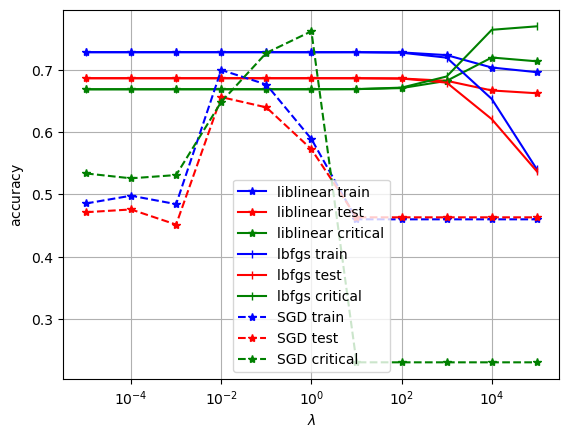

In [29]:
# plot accuracy against regularisation strength
plt.semilogx(lmbdas,train_accuracy,'*-b',label='liblinear train') # liblinear
plt.semilogx(lmbdas,test_accuracy,'*-r',label='liblinear test')
plt.semilogx(lmbdas,critical_accuracy,'*-g',label='liblinear critical')

plt.semilogx(lmbdas,train_accuracy2,'b', marker="|", label='lbfgs train') # newton-cg 0.6830 // 
plt.semilogx(lmbdas,test_accuracy2,'r', marker="|", label='lbfgs test')
plt.semilogx(lmbdas,critical_accuracy2,'g', marker="|", label='lbfgs critical')

plt.semilogx(lmbdas,train_accuracy_SGD,'*--b',label='SGD train')
plt.semilogx(lmbdas,test_accuracy_SGD,'*--r',label='SGD test')
plt.semilogx(lmbdas,critical_accuracy_SGD,'*--g',label='SGD critical')

plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')

plt.grid()
plt.legend()


plt.show()

## Interpreting the results

The first thing we can read off the figure above is the relative degree of overfitting. This information is contained in the difference in accuracy of our model on the training (blue) and test (red) datasets. Notice that the accuracy difference between test and training sets is significant but not unreasonable, within $10\%$. Interestingly, which optimizer performs better depends on the value of the regularization strength. Moreover, similar to the Linear Regression examples, we find that there exists a sweet spot for the regularization strength $\lambda$ that results in optimal performance of the logistic regressor, at about $\lambda\sim 10^{-1}$.

Due to the physics of the Ising model close to criticality, we expect that predicting the phase of a sample will become much more difficult close to the critical point. We can visually see this by looking at the states in the critical region, (see Fig. above and plot other examples). Notice that it is no longer easy even for a trained human eye to distinguish between the ferromagnetic and the disordered phases close to $T_c$. 

It is an interesting exercise to compare the training and test accuracies in the ordered and disordered phases to the accuracy of the model near the critical point (i.e. critical states). Recall that the model is not trained on critical states. Notice that the accuracy is about $10\%$ smaller for the critical states (green curves). 


### Exercises: ###  
<ul>
<li> Change the regularization to $L^1$, or $L^1+L^2$ (i.e. elastic net, see Notebook 2 for more details), and study the performance of the model.
<br><span style="color:blue">  
 </span>
    
<img src="https://github.com/DBustamante98/ML/blob/main/NB6_3.jpg?raw=true"  width="500" height="300">

<br><span style="color:blue">      
For non-critical data, the elastic net regularization seems to provide very good results for $\lambda=10^{-3}$. With the correct value of $\lambda$, all regularization methods seem to have the same predictive performance with critical data.
  </span>  
<li> Try out different solvers supported by `LogisticRegression()`, [see online scikit documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). How do they compare to `liblinear` and `SGD`?

 <img src="https://github.com/DBustamante98/ML/blob/main/NB6_4.png?raw=true"  width="500" height="300">   
    
<br><span style="color:blue">  
For values of $\lambda<10^2$, the performance of the other models (<code>lbfgs</code>, <code>newton-cg</code>, <code>sag</code>, <code>saga</code>) is identical to that of <code>liblinear</code>. However, there is an improvement in predictive power for critical data when $\lambda = 10^4$.   
</span>

<li> One can expect the regressor to be maximally confused exactly at the critical point. Take the data states for the closest temperature, i.e. $T/J=2.5$, and check the performance of the model. Do we get an accuracy of about $50\%$? Does this depend on the proportion of ordered to disordered states in the training set?
<br><span style="color:blue">  
An accuracy of 0.6843 can be obtained when 66.7% of the critical data corresponds to ordered states. Similarly, an accuracy of 0.7692 is obtained when 76.9% of the critical data is ordered states and an accuracy of 1 when all critical data is ordered states. Therefore, the accuracy of a model in the critical regime is sensitive to the proportion of ordered states in the dataset that is used to estimate that accuracy.
</span>

<li> Take the regressor trained on the square lattice Ising model, and try to predict the phases on a different lattice geometry (e.g. triangular or honeycomb). What accuracy do you obtain? Can you roughly locate the critical point in this new model? Note that this requires you to generate your own dataset using Monte-Carlo sampling.
 <br><span style="color:blue"> 
   The model does not seem to have a good performance for the new (triangular) structure; it only allows one to estimate a critical temperature of $T \sim 5-6$.
</span>
 <img src="https://github.com/DBustamante98/ML/blob/main/NB6_5.png?raw=true"  width="500" height="300">   
</ul>

4.768332481826996


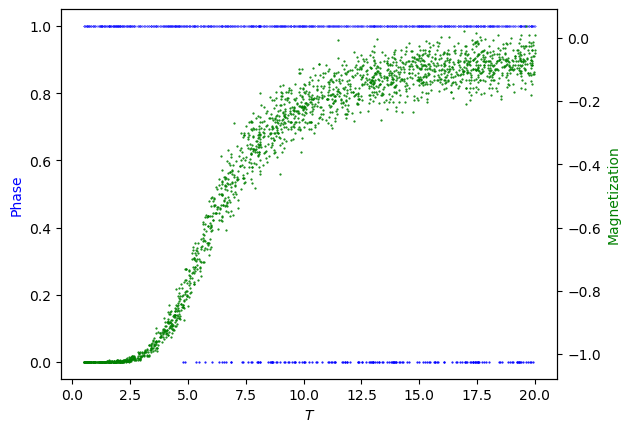

In [53]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

TV1 = []; PV1 = []; TV2 = []; PV2 = [];
for i in range(len(PHASE_vector)):
    if PHASE_vector[i] == 1:
        TV1.append( TEMPERATURE_vector[i]  )
        PV1.append( PHASE_vector[i] )
    else:
        TV2.append( TEMPERATURE_vector[i]  )
        PV2.append( PHASE_vector[i] )            

ax1.scatter(TV1, PV1, color="b", s=0.01)
ax1.scatter(TV2, PV2, color="b", s=0.3)
ax2.scatter(TEMPERATURE_vector, MAGNETIZATION_vector, color="g", s=0.3)
ax1.set_xlabel("$T$"); ax1.set_ylabel("Phase", color="blue"); ax2.set_ylabel("Magnetization", color="green"); 
print(min(TV2))

[[-1], [-1, 1], [1, 1, 1], [1, 1, -1, -1], [1, 1, -1, -1, -1], [1, -1, 1, 1, 1, -1], [-1, 1, 1, 1, 1, 1, 1], [1, 1, -1, 1, -1, -1, -1, -1], [1, 1, 1, 1, -1, 1, -1, -1, 1], [1, 1, -1, 1, 1, -1, -1, -1, -1, 1], [-1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1], [-1, -1, 1, 1, -1, -1, 1, -1, -1, -1, -1, 1], [1, -1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1], [-1, 1, -1, 1, 1, 1, 1, -1, -1, -1, 1, 1, 1, 1], [1, 1, 1, 1, 1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1], [-1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, -1, 1, 1, 1, 1], [1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, -1, -1], [-1, -1, 1, -1, 1, -1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1, 1], [-1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1], [-1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1], [-1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1], [1, -1, -1, -1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1], [1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 

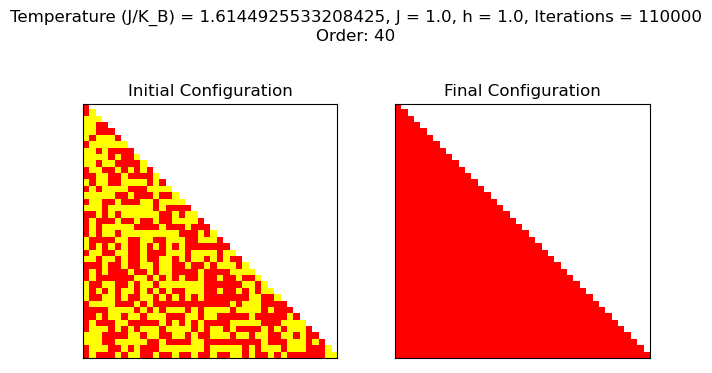

In [32]:
logreg=linear_model.LogisticRegression(C=1.0/1e+4,random_state=1,verbose=0,max_iter=1E3,tol=1E-5,
                                           solver='lbfgs')
logreg.fit(X_train, Y_train)

TEMPERATURE_vector = np.random.uniform(low=0.5, high=20, size=1) # 2000
PHASE_vector = []
MAGNETIZATION_vector = []

for temp in TEMPERATURE_vector:
    sample = IsingTriangle(40).basicIter(iters=110000, temp=temp, plot=True); # IsingSquare IsingHexagon IsingTriangle
    sample = [0 if i==8 else i for i in np.concatenate(sample[-1])]
    PHASE_vector.append( logreg.predict([ sample ])[0]  )
    MAGNETIZATION_vector.append( 2*sum(sample)/len(sample)  )

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import math
from matplotlib import colors
import copy
import random

class IsingSquare:

    # initialise a spin lattice and populate with random spins
    def __init__(self, order, interactionVal=1, magMoment=1):

        if order < 3:
            raise ValueError('Order number needs to be greater than 2.')

        self.temp = 0.0
        self.beta = 0.0
        self.boltzmann = 1.38064852 * (10 ** -23)
        self.order = order

        self.J = float(interactionVal)
        self.h = float(magMoment)

        self.magList = []
        self.specHeatList = []
        self.energyList = []
        self.suscepList = []

        self.spins = []
        self.resetSpins()

    # reset the spin lattice to a random configuration
    def resetSpins(self):
        vals = np.array([-1, 1])

        self.spins = np.random.choice(vals, size=(self.order, self.order))

    # returns an array of an atom's 4 nearest neighbours
    def neighbours(self, row, col):

        return np.asarray([self.spins[row][col - 1],                 #left
                           self.spins[row][(col + 1) % self.order],  #right
                           self.spins[row - 1][col],                 #up
                           self.spins[(row + 1) % self.order][col]]) #down

    # calculates the energy of a single atom, using the Hamiltonian
    def singleEnergy(self, row, col):

        neighbours = self.neighbours(row, col)
        selfSpin = self.spins[row][col]
        return self.J * selfSpin * np.sum(np.sum(neighbours)) - self.h * selfSpin

    # calculates the magnitude of the entire energy of the lattice
    def totalEnergy(self):

        energy = 0.0
        for i in np.arange(self.order):
            for j in np.arange(self.order):
                energy += self.singleEnergy(i, j)

        # to avoid counting pairs twice, divide by two
        # divide by maximum possible energy to normalise
        return math.fabs(energy) / (self.order * self.order * (-4 * self.J - self.h) )

    # calculates the magnitude of the residual magnetic spin of the lattice
    # normalise by dividing by order of lattice squared
    def totalMag(self):
        return math.fabs(np.sum(np.sum(self.spins)) / (self.order ** 2))

    def specHeat(self, energy, energySquared, temp):
        return (energySquared - energy ** 2) * (1 / (self.order * self.order * 2 * temp * temp))

    def suscep(self, mag, magSquared, temp):
        return self.J * (magSquared - mag ** 2) * (1 / (self.order * self.order * 2 * temp))
    # attempts to flip a random spin using the metropolis algorithm and the Boltzmann distribution
    def tryFlip(self, row, col):
        # energy change = -2 * E_initial
        # so accept change if E_initial >= 0

        energy = self.singleEnergy(row, col)

        if energy <= 0 or np.random.random() <= math.exp(-self.beta * 2 * energy):
            self.spins[row][col] *= -1

    # closes plot window
    def close_event(self):
        plt.close()  # timer calls this function after 3 seconds and closes the window

    # plots a meshgrid of the initial and final spin lattices
    def plotStartEndSpins(self, spinsList, iters=1000000):

        cmap = colors.ListedColormap(['red', 'yellow'])
        bounds = [-1, 0, 1]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        plt.subplots(nrows=1, ncols=2)
        plt.tight_layout()

        plt.subplot(1,2,1)
        plt.imshow(spinsList[0], cmap=cmap, norm=norm)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('Initial Configuration')

        plt.subplot(1, 2, 2)
        plt.imshow(spinsList[1], cmap=cmap, norm=norm)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('Final Configuration')

        title = "Temperature (J/K_B) = {0}, J = {1}, h = {2}, Iterations = {3}".format(self.temp, self.J, self.h, iters) + "\n" + "Order: {0} x {1}".format(self.order, self.order)
        plt.suptitle(title)

        plt.show()

    # simulates the lattice at a constant temperature temp, for iters iterations, plots the resulting lattices, and returns the spin configurations
    def basicIter(self, iters=1000000, temp=1, plot=False):

        self.resetSpins()
        spinsList = [copy.deepcopy(self.spins)];

        self.temp = temp;
        self.beta = 1.0 / self.temp;

        for i in np.arange(iters + 1):
            row, col = np.random.randint(self.order), np.random.randint(self.order);
            self.tryFlip(row, col);

        spinsList.append(self.spins);

        if plot:
            self.plotStartEndSpins(spinsList, iters);
        else:
            for i in np.arange(len(spinsList[0])):
                spinsList[0][i] = np.asarray(spinsList[0][i]);

            for i in np.arange(len(spinsList[1])):
                spinsList[1][i] = np.asarray(spinsList[1][i]);

            spinsList = np.array(spinsList);

        return spinsList

    # simulates the lattice oer a temperature range tempRange, with itersPerTemp iterations per temperature
    # plotProperties: plot the residual spin, total energy, susceptibility and specific heat
    def tempRangeIter(self, tempRange=np.arange(start=0.8, stop=3.2, step=0.05), itersPerTemp=100000, plotProperties=False):

        self.resetSpins()

        # store the averages here
        energyList = []
        magList = []
        specHeatList = []
        suscepList = []

        for temp in tempRange:
            self.beta = 1.0 / temp
            print("Calculating temp:", temp)

            # allow to reach equilibrium
            for i in np.arange(itersPerTemp + 1):
                row, col = np.random.randint(0, self.order), np.random.randint(0, self.order)
                self.tryFlip(row, col)

            #do a further thousand iterations to get average, and every hundred iterations, store the properties
            if plotProperties:

                #store the values used to calculate averages here
                magListEquilib = []
                energyListEquilib = []

                for i in np.arange(500000):

                    if i % 5000 == 0:

                        energy = self.totalEnergy()
                        mag = self.totalMag()

                        energyListEquilib.append(energy)
                        magListEquilib.append(mag)

                    row, col = np.random.randint(0, self.order), np.random.randint(0, self.order)
                    self.tryFlip(row, col)

                energyAvg = np.average(energyListEquilib)
                energySquaredAvg = np.average(np.square(energyListEquilib))
                magAvg = np.average(magListEquilib)
                magSquaredAvg = np.average(np.square(magListEquilib))

                energyList.append(energyAvg)
                magList.append(magAvg)
                specHeatList.append(self.specHeat(energyAvg, energySquaredAvg, temp))
                suscepList.append(self.suscep(magAvg, magSquaredAvg, temp))

            # reset the spins for the next temperature
            self.resetSpins()

        if plotProperties:

            plt.tight_layout()

            plt.subplot(2, 2, 1)
            plt.plot(tempRange, energyList)
            plt.title("Total Energy")
            plt.axvline(x=2.269185, c='r', linestyle='--')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])

            plt.subplot(2, 2, 2)
            plt.plot(tempRange, magList)
            plt.title("Residual Spin")
            plt.axvline(x=2.269185, c='r', linestyle='--')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(tempRange, specHeatList)
            plt.title("Specific Heat Capacity")
            plt.axvline(x=2.269185, c='r', linestyle='--')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(tempRange, suscepList)
            plt.title("Susceptibility")
            plt.axvline(x=2.269185, c='r', linestyle='--')
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.show()

class IsingTriangle:

    # initialise a spin lattice and populate with random spins
    def __init__(self, order, interactionVal=1, magMoment=1):

        if order < 4:
            raise ValueError('Order number needs to be greater than 3.')

        self.temp = 0.0
        self.beta = 0.0
        self.boltzmann = 1.38064852 * (10 ** -23)
        self.order = order
        self.J = float(interactionVal)
        self.h = float(magMoment)

        self.magList = []
        self.specHeatList = []
        self.energyList = []
        self.suscepList = []

        self.spins = []
        self.resetSpins()

    # reset the spin lattice to a random configuration
    def resetSpins(self):
        self.spins = []

        vals = np.array([1, -1])

        for i in np.arange(self.order):
            self.spins.append(list(np.random.choice(vals, size=i + 1)))

    # returns an array of an atom's 6 nearest neighbours
    def neighbours(self, row, col):

        # centre atoms
        if 1 < row < self.order - 1 and 0 < col < row:
            return np.asarray([self.spins[row - 1][col - 1],
                              self.spins[row - 1][col],

                              self.spins[row][col - 1],
                              self.spins[row][col + 1],

                              self.spins[row + 1][col],
                              self.spins[row + 1][col + 1]])

        # left side central
        elif 0 < row < self.order - 1 and col == 0:
            return np.asarray([self.spins[row - 1][0],
                              self.spins[row][1],

                              self.spins[row + 1][0],
                              self.spins[row + 1][1],

                              self.spins[row][row],
                              self.spins[row - 1][row - 1]])

        # right side central
        elif 0 < row < self.order - 1 and col == row:
            return np.asarray([self.spins[row - 1][row - 1],
                              self.spins[row - 1][0],

                              self.spins[row][row - 1],
                              self.spins[row][0],

                              self.spins[row + 1][row],
                              self.spins[row + 1][row + 1]])

        # bottom side central
        elif row == self.order - 1 and 0 < col < row:
            return np.asarray([self.spins[row - 1][col - 1],
                               self.spins[row - 1][col],

                               self.spins[row][col - 1],
                               self.spins[row][col + 1],

                               self.spins[0][0],
                               self.spins[0][0]])

        # very top
        elif row == 0:
            return np.asarray([self.spins[1][0],
                              self.spins[1][1],

                              self.spins[self.order - 1][0],
                              self.spins[self.order - 1][self.order - 1],

                              self.spins[self.order - 1][1],
                              self.spins[self.order - 1][self.order - 2]])
        # bottom left
        elif row == self.order - 1 and col == 0:
            return np.asarray([self.spins[row - 1][0],
                               self.spins[row - 1][row - 1],

                               self.spins[row][1],
                               self.spins[row][row],

                               self.spins[0][0],
                               self.spins[0][0]])

        # bottom right
        elif row == self.order - 1 and (col == row):
            return np.asarray([self.spins[row - 1][0],
                               self.spins[row - 1][row - 1],

                               self.spins[row][0],
                               self.spins[row][row - 1],

                               self.spins[0][0],
                               self.spins[0][0]])

    # calculates the energy of a single atom, using the Hamiltonian
    def singleEnergy(self, row, col):

        neighbours = self.neighbours(row, col)
        selfSpin = self.spins[row][col]
        return self.J * selfSpin * np.sum(np.sum(neighbours)) - self.h * selfSpin

    # calculates the magnitude of the entire energy of the lattice
    def totalEnergy(self):

        energy = 0.0
        for i in np.arange(self.order):
            for j in np.arange(len(self.spins[i])):
                energy += self.singleEnergy(i, j)

        # to avoid counting pairs twice, divide by two
        # divide by maximum possible energy to normalise
        return -math.fabs(energy / ((-6 * self.J - self.h)  * ((self.order ** 2 + self.order) / 2)))

    # calculates the magnitude of the residual magnetic spin of the lattice
    # normalise by dividing by order of lattice squared
    def totalMag(self):
        return math.fabs((np.sum(np.sum(self.spins)) * 2) / (self.order ** 2 + self.order))

    def specHeat(self, energy, energySquared, temp):
        return (energySquared - energy ** 2) * (1 / (self.order * self.order * 2 * temp * temp))

    def suscep(self, mag, magSquared, temp):
        return self.J * (magSquared - mag ** 2) * (1 / (self.order * self.order * 2 * temp))
    # attempts to flip a random spin using the metropolis algorithm and the Boltzmann distribution
    def tryFlip(self, row, col):
        # energy change = -2 * E_initial
        # so accept change if E_initial <= 0

        energy = self.singleEnergy(row, col)

        if energy <= 0 or np.random.random() <= math.exp(-self.beta * 2 * energy):
            self.spins[row][col] *= -1

    # closes plot window
    def close_event(self):
        plt.close()  # timer calls this function after 3 seconds and closes the window

    # plots a meshgrid of the initial and final spin lattices
    def plotStartEndSpins(self, spinsList, iters=1000000):

        for i in np.arange(self.order):
            for j in np.arange(self.order - i - 1):

                spinsList[0][i].append(8)
                spinsList[1][i].append(8)

        cmap = colors.ListedColormap(['red', 'yellow', 'white'])
        bounds = [-1, 0, 2, 10]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        plt.subplots(nrows=1, ncols=2)
        plt.tight_layout()
        for i in np.arange(len(spinsList[0])):
            spinsList[0][i] = np.asarray(spinsList[0][i])

        for i in np.arange(len(spinsList[1])):
            spinsList[1][i] = np.asarray(spinsList[1][i])

        spinsList = np.array(spinsList)

        plt.subplot(1,2,1)
        plt.imshow(spinsList[0], cmap=cmap, norm=norm)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('Initial Configuration')

        plt.subplot(1, 2, 2)
        plt.imshow(spinsList[1], cmap=cmap, norm=norm)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('Final Configuration')

        title = "Temperature (J/K_B) = {0}, J = {1}, h = {2}, Iterations = {3}".format(self.temp, self.J, self.h, iters) + "\n" + "Order: {0}".format(self.order,)
        plt.suptitle(title)

        # timer = fig.canvas.new_timer(
        #     interval=graphInterval)  # creating a timer object and setting an interval of 3000 milliseconds
        # timer.add_callback(self.close_event)
        # timer.start()
        plt.show()

    # simulates the lattice at a constant temperature temp, for iters iterations, and returns the spin configurations
    def basicIter(self, iters=1000000, temp=1, plot=False):

        self.resetSpins()
        spinsList = [copy.deepcopy(self.spins)]

        self.temp = temp
        self.beta = 1.0 / self.temp

        for i in np.arange(iters + 1):
            row = np.random.randint(self.order)
            col = np.random.randint(row + 1)
            self.tryFlip(row, col)

        spinsList.append(self.spins)

        print(spinsList[0])
        print(spinsList[1])

        if plot:
            self.plotStartEndSpins(spinsList, iters)
        else:
            for i in np.arange(len(spinsList[0])):
                spinsList[0][i] = np.asarray(spinsList[0][i])

            for i in np.arange(len(spinsList[1])):
                spinsList[1][i] = np.asarray(spinsList[1][i])

            spinsList = np.array(spinsList)
        return spinsList

    # simulates the lattice oer a temperature range tempRange, with itersPerTemp iterations per temperature
    # plotProperties: plot the residual spin, total energy, susceptibility and specific heat
    def tempRangeIter(self, tempRange=np.arange(start=1, stop=5, step=0.2), itersPerTemp=100000, plotProperties=False):

        self.resetSpins()

        # store the averages here
        energyList = []
        magList = []
        specHeatList = []
        suscepList = []

        for temp in tempRange:
            self.beta = 1.0 / temp
            print("Calculating temp:", temp)

            # allow to reach equilibrium
            for i in np.arange(itersPerTemp + 1):
                row = np.random.randint(self.order)
                col = np.random.randint(row + 1)
                self.tryFlip(row, col)

            #do a further ten thousand iterations to get average, and every two hundred iterations, store the properties
            if plotProperties:

                #store the values used to calculate averages here
                magListEquilib = []
                energyListEquilib = []

                for i in np.arange(10000):

                    if i % 200 == 0:

                        energy = self.totalEnergy()
                        mag = self.totalMag()

                        energyListEquilib.append(energy)
                        magListEquilib.append(mag)

                    row = np.random.randint(self.order)
                    col = np.random.randint(row + 1)
                    self.tryFlip(row, col)

                energyAvg = np.average(energyListEquilib)
                energySquaredAvg = np.average(np.square(energyListEquilib))
                magAvg = np.average(magListEquilib)
                magSquaredAvg = np.average(np.square(magListEquilib))

                energyList.append(energyAvg)
                magList.append(magAvg)
                specHeatList.append(self.specHeat(energyAvg, energySquaredAvg, temp))
                suscepList.append(self.suscep(magAvg, magSquaredAvg, temp))

            # reset the spins for the next temperature
            self.resetSpins()

        if plotProperties:

            plt.tight_layout()

            plt.subplot(2, 2, 1)
            plt.plot(tempRange, energyList)
            plt.title("Total Energy")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])

            plt.subplot(2, 2, 2)
            plt.plot(tempRange, magList)
            plt.title("Residual Spin")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(tempRange, specHeatList)
            plt.title("Specific Heat Capacity")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(tempRange, suscepList)
            plt.title("Susceptibility")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.show()

class IsingHexagon:

    # initialise a spin lattice and populate with random spins
    def __init__(self, order, interactionVal=1, magMoment=1):

        if order < 2:
            raise ValueError('Order number needs to be greater than 3.')

        self.temp = 0.0
        self.beta = 0.0
        self.boltzmann = 1.38064852 * (10 ** -23)
        self.order = order
        self.J = float(interactionVal)
        self.h = float(magMoment)

        self.magList = []
        self.specHeatList = []
        self.energyList = []
        self.suscepList = []

        self.resetSpins()

    # reset the spin lattice to a random configuration
    def resetSpins(self):
        self.spins = []

        vals = np.array([1, -1])

        if self.order == 1:
            self.spins.append(list(np.random.choice(vals, size=2)))
            self.spins.append(list(np.random.choice(vals, size=2)))
            self.spins.append(list(np.random.choice(vals, size=2)))
            self.spins = np.array(self.spins)
            return

        # top layers
        iter = 2
        while self.order >= iter / 2.0 and not iter == 2 * self.order:
            self.spins.append(list(np.random.choice(vals, size=iter)))
            iter += 2
        # middle layers
        for i in np.arange(5 + 2 * (self.order - 2)):
            self.spins.append(list(np.random.choice(vals, size=2 * self.order)))
        # bottom layers
        iter = 2 * self.order - 2
        while iter > 0:
            self.spins.append(list(np.random.choice(vals, size= iter)))
            iter -= 2

    # returns the nearest neighbours for centre atoms, used in the main nearest neighbour function
    def centreReturn(self, left, row, col): # left is boolean, when true, use atom to left, otherwise, use atom to right
        if left:
            return np.asarray([self.spins[row - 1][col],
                          self.spins[row][col - 1],
                          self.spins[row + 1][col]])
        else:
            return np.asarray([self.spins[row - 1][col],
                              self.spins[row][col + 1],
                              self.spins[row + 1][col]])

    # returns an array of an atom's 3 nearest neighbours
    def neighbours(self, row, col):
        # centre atoms
        if 1 < row < 4 * self.order - 3:
            if self.order - 1 < row < 3 * self.order - 1 and 0 < col < len(self.spins[row]) - 1:
                # handles centre atoms
                if self.order % 2 == 0:
                    if (row - col) % 2 == 0:
                        return self.centreReturn(True, row, col)
                    else:
                        return self.centreReturn(False, row, col)
                else:
                    if (row - col) % 2 == 0:
                        return self.centreReturn(False, row, col)
                    else:
                        return self.centreReturn(True, row, col)

            elif (row < self.order or row > 3 * self.order - 2) and 1 < col < len(self.spins[row]) - 2:
                # handles centre atoms
                if self.order % 2 == 0:
                    if (row - col) % 2 == 0:
                        return self.centreReturn(True, row, col)
                    else:
                        return self.centreReturn(False, row, col)
                else:
                    if (row - col) % 2 == 0:
                        return self.centreReturn(False, row, col)
                    else:
                        return self.centreReturn(True, row, col)

        # left
        # incorrect but works
        if self.order - 1 < row < (3 * self.order - 1) and col < 2:
            return np.asarray([self.spins[row - 1][0],
                               self.spins[row + 1][0],
                               self.spins[row][len(self.spins[row]) - 1]])
        # right
        # incorrect but works
        elif self.order - 1 < row < (3 * self.order - 1) and col > len(self.spins[row]) - 3:
            return np.asarray([self.spins[row - 1][col],
                               self.spins[row + 1][col],
                               self.spins[row][0]])
        # annoying left corner atoms
        elif (row < self.order or row > 3 * self.order - 2) and col < 2 and len(self.spins[row]) > 2:
            if col == 0:
                # top left corner
                if row < 2 * (self.order - 1):
                    return np.asarray([self.spins[row + 1][1],
                                       self.spins[row][1],
                                       self.spins[row][len(self.spins[row]) - 1]])
                # bottom left corner
                else:
                    return np.asarray([self.spins[row - 1][1],
                                       self.spins[row][1],
                                       self.spins[row][len(self.spins[row]) - 1]])
            else:
                # top left corner
                if row < 2 * (self.order - 1):
                    return np.asarray([self.spins[row][0],
                                       self.spins[row - 1][0],
                                       self.spins[row + 1][2]])
                # bottom left corner
                else:
                    return np.asarray([self.spins[row][0],
                                       self.spins[row - 1][2],
                                       self.spins[row + 1][0]])

        # annoying right corner atoms
        elif (row < self.order or row > 3 * self.order - 2) and col > len(self.spins[row]) - 3 and len(self.spins[row]) > 2:
            if not col % 2 == 0:
                # top right corner
                if row < 2 * (self.order - 1):
                    try:
                        return np.asarray([self.spins[row + 1][col + 1],
                                           self.spins[row][col - 1],
                                           self.spins[row][0]])
                    except IndexError:
                        return np.asarray([self.spins[row + 1][col],
                                           self.spins[row][col - 1],
                                           self.spins[row][0]])
                # bottom right corner
                else:
                    try:
                        return np.asarray([self.spins[row - 1][col + 1],
                                           self.spins[row][col - 1],
                                           self.spins[row][0]])
                    except IndexError:
                        return np.asarray([self.spins[row - 1][col],
                                           self.spins[row][col - 1],
                                           self.spins[row][0]])
            else:
                # top right corner
                if row < 2 * (self.order - 1):
                    return np.asarray([self.spins[row][col + 1],
                                       self.spins[row - 1][col - 1],
                                       self.spins[row + 1][col]])
                # bottom right corner
                else:
                    return np.asarray([self.spins[row][col + 1],
                                       self.spins[row - 1][col + 1],
                                       self.spins[row + 1][col - 1]])
        # top
        elif row == 0:
            if col == 0:
                return np.asarray([self.spins[0][1],
                                   self.spins[1][1],
                                   self.spins[4 * self.order - 2][0]])
            else:
                return np.asarray([self.spins[0][0],
                                   self.spins[1][2],
                                   self.spins[4 * self.order - 2][1]])
        # bottom
        # don't have to check for anything, only option remaining
        elif col == 0:
            return np.asarray([self.spins[row][1],
                               self.spins[row - 1][1],
                               self.spins[0][0]])
        else:
            return np.asarray([self.spins[row][0],
                               self.spins[1][2],
                               self.spins[0][1]])


    # calculates the energy of a single atom, using the Hamiltonian
    def singleEnergy(self, row, col):

        neighbours = self.neighbours(row, col)
        selfSpin = self.spins[row][col]
        return self.J * selfSpin * np.sum(np.sum(neighbours)) - self.h * selfSpin

    # calculates the magnitude of the entire energy of the lattice
    def totalEnergy(self):

        energy = 0.0
        for i in np.arange(len(self.spins)):
            for j in np.arange(len(self.spins[i])):
                energy += self.singleEnergy(i, j)
        # to avoid counting pairs twice, divide by two
        # divide by maximum possible energy to normalise
        return -math.fabs(energy / ((3 * self.J + self.h) * (6 * self.order * self.order))) #( * (-3 * self.J - self.h)

    # calculates the magnitude of the residual magnetic spin of the lattice
    # normalise by dividing by order of lattice squared
    def totalMag(self):
        sum = 0
        for i in np.arange(len(self.spins)):
            sum += np.sum(self.spins[i])

        return math.fabs(float(sum) / (6 * self.order ** 2))

    def specHeat(self, energy, energySquared, temp):
        return (energySquared - energy ** 2) * (1 / (self.order * self.order * 2 * temp * temp))

    def suscep(self, mag, magSquared, temp):
        return self.J * (magSquared - mag ** 2) * (1 / (self.order * self.order * 2 * temp))
    # attempts to flip a random spin using the metropolis algorithm and the Boltzmann distribution
    def tryFlip(self, row, col):
        # energy change = -2 * E_initial
        # so accept change if E_initial <= 0

        energy = self.singleEnergy(row, col)

        if energy <= 0 or np.random.random() <= math.exp(-self.beta * 2 * energy):
            self.spins[row][col] *= -1

    # closes plot window
    def close_event(self):
        plt.close()  # timer calls this function after 3 seconds and closes the window

    # plots a meshgrid of the initial and final spin lattices
    def plotStartEndSpins(self, spinsList, iters=1000000):

        for i in np.arange(2):
            for j in spinsList[i]:
                while len(j) < 2 * self.order:
                    j.insert(0, 8)
                    j.append(8)

        cmap = colors.ListedColormap(['red', 'yellow', 'white'])
        bounds = [-1, 0, 2, 10]
        norm = colors.BoundaryNorm(bounds, cmap.N)

        plt.subplots(nrows=1, ncols=2)
        plt.tight_layout()
        for i in np.arange(len(spinsList[0])):
            spinsList[0][i] = np.asarray(spinsList[0][i])

        for i in np.arange(len(spinsList[1])):
            spinsList[1][i] = np.asarray(spinsList[1][i])

        spinsList = np.array(spinsList)

        plt.subplot(1,2,1)
        plt.imshow(spinsList[0], cmap=cmap, norm=norm)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('Initial Configuration')

        plt.subplot(1, 2, 2)
        plt.imshow(spinsList[1], cmap=cmap, norm=norm)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.title('Final Configuration')

        title = "Temperature (J/K_B) = {0}, J = {1}, h = {2}, Iterations = {3}".format(self.temp, self.J, self.h, iters) + "\n" + "Order: {0}".format(self.order,)
        plt.suptitle(title)

        # timer = fig.canvas.new_timer(
        #     interval=graphInterval)  # creating a timer object and setting an interval of 3000 milliseconds
        # timer.add_callback(self.close_event)
        # timer.start()
        plt.show()

    # simulates the lattice at a constant temperature temp, for iters iterations, and returns the spin configurations
    def basicIter(self, iters=1000000, temp=1, plot=False):

        self.resetSpins()
        spinsList = [copy.deepcopy(self.spins)]

        self.temp = temp
        self.beta = 1.0 / self.temp

        for i in np.arange(iters + 1):
            row = np.random.randint(4 * self.order - 1)
            col = np.random.randint(len(self.spins[row]))
            self.tryFlip(row, col)

        spinsList.append(self.spins)

        if plot:
            self.plotStartEndSpins(spinsList, iters)
        else:
            for i in np.arange(len(spinsList[0])):
                spinsList[0][i] = np.asarray(spinsList[0][i])

            for i in np.arange(len(spinsList[1])):
                spinsList[1][i] = np.asarray(spinsList[1][i])

            spinsList = np.array(spinsList)

        return spinsList

    # simulates the lattice oer a temperature range tempRange, with itersPerTemp iterations per temperature
    # plotProperties: plot the residual spin, total energy, susceptibility and specific heat
    def tempRangeIter(self, tempRange=np.arange(start=1, stop=5, step=0.2), itersPerTemp=100000, plotProperties=False):

        self.resetSpins()

        # store the averages here
        energyList = []
        magList = []
        specHeatList = []
        suscepList = []

        for temp in tempRange:
            self.beta = 1.0 / temp
            print("Calculating temp:", temp)

            # allow to reach equilibrium
            for i in np.arange(itersPerTemp + 1):
                row = np.random.randint(4 * self.order - 1)
                col = np.random.randint(len(self.spins[row]))
                self.tryFlip(row, col)

            #do a further thousand iterations to get average, and every hundred iterations, store the properties
            if plotProperties:

                #store the values used to calculate averages here
                magListEquilib = []
                energyListEquilib = []

                for i in np.arange(20000):

                    if i % 400 == 0:

                        energy = self.totalEnergy()
                        mag = self.totalMag()

                        energyListEquilib.append(energy)
                        magListEquilib.append(mag)

                    row = np.random.randint(4 * self.order - 1)
                    col = np.random.randint(len(self.spins[row]))
                    self.tryFlip(row, col)

                energyAvg = np.average(energyListEquilib)
                energySquaredAvg = np.average(np.square(energyListEquilib))
                magAvg = np.average(magListEquilib)
                magSquaredAvg = np.average(np.square(magListEquilib))

                energyList.append(energyAvg)
                magList.append(magAvg)
                specHeatList.append(self.specHeat(energyAvg, energySquaredAvg, temp))
                suscepList.append(self.suscep(magAvg, magSquaredAvg, temp))

            # reset the spins for the next temperature
            self.resetSpins()

        if plotProperties:

            plt.tight_layout()

            plt.subplot(2, 2, 1)
            plt.plot(tempRange, energyList)
            plt.title("Total Energy")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])

            plt.subplot(2, 2, 2)
            plt.plot(tempRange, magList)
            plt.title("Residual Spin")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.subplot(2, 2, 3)
            plt.plot(tempRange, specHeatList)
            plt.title("Specific Heat Capacity")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.plot(tempRange, suscepList)
            plt.title("Susceptibility")
            plt.tick_params(axis="x", direction="in")
            plt.tick_params(axis="y", direction="in")
            plt.xlim(tempRange[0], tempRange[len(tempRange) - 1])
            plt.legend()

            plt.show()